Link: [link](https://www.kaggle.com/competitions/london-house-price-prediction-advanced-techniques/data)

# **1. Import libraries**

In [1]:
!pip install xgboost

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, Normalizer, LabelEncoder, OneHotEncoder, OrdinalEncoder
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin
from sklearn.pipeline import Pipeline
from statsmodels.tsa.deterministic import DeterministicProcess, CalendarFourier
from sklearn.linear_model import Ridge
from lightgbm import LGBMRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, VotingRegressor
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import mean_absolute_error, r2_score

# 2. **Load dataset**

In [3]:
train_df = pd.read_csv('/kaggle/input/london-house-price-prediction-advanced-techniques/train.csv')
test_df = pd.read_csv('/kaggle/input/london-house-price-prediction-advanced-techniques/test.csv')

In [4]:
combine = [train_df, test_df]

In [5]:
for data in combine:
    data['time'] = pd.to_datetime(dict(year=data['sale_year'], month=data['sale_month'], day = 15))
    data['time'] = data['time'].dt.to_period('M')
    data['time_numeric'] = (data['time'].dt.to_timestamp() - data['time'].min().to_timestamp()) / np.timedelta64(1, 'D')

In [6]:
train_df = train_df.set_index('time')
test_df = test_df.set_index('time')
combine = [train_df, test_df]

In [7]:
train_df.head()

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,ID,fullAddress,postcode,country,outcode,latitude,longitude,bathrooms,bedrooms,floorAreaSqM,livingRooms,tenure,propertyType,currentEnergyRating,sale_month,sale_year,price,time_numeric
time,,,,,,,,,,,,,,,,,,
1995-01,0,"38 Adelina Grove, London, E1 3AD",E1 3AD,England,E1,51.519406,-0.053261,NaN,3.0,80.0,1.0,Freehold,Semi-Detached House,C,1,1995,77000,0.0
1995-01,1,"6 Cleveland Grove, London, E1 4XL",E1 4XL,England,E1,51.521261,-0.053384,2.0,4.0,110.0,1.0,Leasehold,Terrace Property,D,1,1995,89995,0.0
1995-01,2,"65 Sanderstead Road, London, E10 7PW",E10 7PW,England,E10,51.569054,-0.034892,1.0,3.0,84.0,1.0,Freehold,Terrace Property,D,1,1995,59000,0.0
1995-01,3,"5 Queenswood Gardens, London, E11 3SE",E11 3SE,England,E11,51.564212,0.026292,NaN,2.0,72.0,1.0,Leasehold,Purpose Built Flat,NaN,1,1995,51500,0.0
1995-01,4,"12 Woodlands Road, London, E11 4RW",E11 4RW,England,E11,51.563430,0.006260,1.0,3.0,104.0,1.0,Freehold,Mid Terrace House,D,1,1995,63500,0.0


In [8]:
test_df.head()

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,ID,fullAddress,postcode,country,outcode,latitude,longitude,bathrooms,bedrooms,floorAreaSqM,livingRooms,tenure,propertyType,currentEnergyRating,sale_month,sale_year,time_numeric
time,,,,,,,,,,,,,,,,,
2024-01,266325,"Flat 7, Philip House, Heneage Street, London, ...",E1 5LW,England,E1,51.518783,-0.071003,1.0,2.0,54.0,1.0,Leasehold,Flat/Maisonette,D,1,2024,0.0
2024-01,266326,"17 Bowmans Mews, London, E1 8RY",E1 8RY,England,E1,51.511624,-0.068236,1.0,1.0,48.0,1.0,Leasehold,Purpose Built Flat,D,1,2024,0.0
2024-01,266327,"Flat 30, Everard House, Boyd Street, London, E...",E1 1LY,England,E1,51.512737,-0.066502,1.0,NaN,32.0,NaN,Leasehold,Flat/Maisonette,C,1,2024,0.0
2024-01,266328,"Flat 1, Wilton Court, Cavell Street, London, E...",E1 2BN,England,E1,51.516165,-0.057334,1.0,3.0,85.0,1.0,Leasehold,Purpose Built Flat,D,1,2024,0.0
2024-01,266329,"45 Musbury Street, London, E1 0PJ",E1 0PJ,England,E1,51.515115,-0.051008,1.0,2.0,82.0,1.0,Leasehold,Flat/Maisonette,C,1,2024,0.0


In [9]:
print('Features: \n', train_df.columns)

Features: 
 Index(['ID', 'fullAddress', 'postcode', 'country', 'outcode', 'latitude',
       'longitude', 'bathrooms', 'bedrooms', 'floorAreaSqM', 'livingRooms',
       'tenure', 'propertyType', 'currentEnergyRating', 'sale_month',
       'sale_year', 'price', 'time_numeric'],
      dtype='object')


## Preliminary Information

In [10]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 266325 entries, 1995-01 to 2023-12
Freq: M
Data columns (total 18 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   ID                   266325 non-null  int64  
 1   fullAddress          266325 non-null  object 
 2   postcode             266325 non-null  object 
 3   country              266325 non-null  object 
 4   outcode              266325 non-null  object 
 5   latitude             266325 non-null  float64
 6   longitude            266325 non-null  float64
 7   bathrooms            217846 non-null  float64
 8   bedrooms             241482 non-null  float64
 9   floorAreaSqM         252519 non-null  float64
 10  livingRooms          229285 non-null  float64
 11  tenure               260604 non-null  object 
 12  propertyType         265817 non-null  object 
 13  currentEnergyRating  209511 non-null  object 
 14  sale_month           266325 non-null  int64  
 15  s

In [11]:
train_df.describe()

,ID,latitude,longitude,bathrooms,bedrooms,floorAreaSqM,livingRooms,sale_month,sale_year,price,time_numeric
count,266325.000000,266325.000000,266325.000000,217846.000000,241482.000000,252519.000000,229285.000000,266325.000000,266325.000000,2.663250e+05,266325.000000
mean,133162.000000,51.510090,-0.104639,1.439471,2.496140,99.624088,1.292160,6.805670,2012.213855,6.161788e+05,6463.419750
std,76881.549558,0.056709,0.088074,0.721365,1.172209,56.454683,0.583029,3.356693,9.143113,1.274105e+06,3343.344669
min,0.000000,51.385708,-0.347055,1.000000,1.000000,10.000000,1.000000,1.000000,1995.000000,1.000000e+04,0.000000
25%,66581.000000,51.466685,-0.159167,1.000000,2.000000,63.000000,1.000000,4.000000,2004.000000,2.165000e+05,3378.000000
50%,133162.000000,51.507202,-0.108622,1.000000,2.000000,85.000000,1.000000,7.000000,2014.000000,3.850000e+05,7183.000000
75%,199743.000000,51.550937,-0.049202,2.000000,3.000000,118.000000,1.000000,10.000000,2021.000000,6.500000e+05,9709.000000
max,266324.000000,51.665823,0.139249,9.000000,9.000000,500.000000,9.000000,12.000000,2023.000000,1.000000e+08,10561.000000


In [12]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 16547 entries, 2024-01 to 2024-08
Freq: M
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   16547 non-null  int64  
 1   fullAddress          16547 non-null  object 
 2   postcode             16547 non-null  object 
 3   country              16547 non-null  object 
 4   outcode              16547 non-null  object 
 5   latitude             16547 non-null  float64
 6   longitude            16547 non-null  float64
 7   bathrooms            13923 non-null  float64
 8   bedrooms             15172 non-null  float64
 9   floorAreaSqM         14541 non-null  float64
 10  livingRooms          14452 non-null  float64
 11  tenure               15957 non-null  object 
 12  propertyType         16380 non-null  object 
 13  currentEnergyRating  15050 non-null  object 
 14  sale_month           16547 non-null  int64  
 15  sale_year          

In [13]:
test_df.describe()

,ID,latitude,longitude,bathrooms,bedrooms,floorAreaSqM,livingRooms,sale_month,sale_year,time_numeric
count,16547.000000,16547.000000,16547.000000,13923.000000,15172.000000,14541.000000,14452.000000,16547.000000,16547.0,16547.000000
mean,274598.000000,51.510075,-0.112089,1.458091,2.523069,98.029915,1.306255,3.915574,2024.0,88.465160
std,4776.851788,0.058946,0.094244,0.732714,1.181028,54.491746,0.588833,2.123115,0.0,64.445099
min,266325.000000,51.386308,-0.346560,1.000000,1.000000,10.000000,1.000000,1.000000,2024.0,0.000000
25%,270461.500000,51.465022,-0.186330,1.000000,2.000000,63.000000,1.000000,2.000000,2024.0,31.000000
50%,274598.000000,51.503620,-0.112590,1.000000,2.000000,84.000000,1.000000,4.000000,2024.0,91.000000
75%,278734.500000,51.551877,-0.038815,2.000000,3.000000,114.000000,2.000000,6.000000,2024.0,152.000000
max,282871.000000,51.663743,0.137557,9.000000,9.000000,499.000000,7.000000,8.000000,2024.0,213.000000


In [14]:
train_df['price'].head()

time
1995-01    77000
1995-01    89995
1995-01    59000
1995-01    51500
1995-01    63500
Freq: M, Name: price, dtype: int64

# **3. EDA**

In [15]:
num_features = ['latitude',	'longitude',	'bathrooms',	'bedrooms', \
                                  'floorAreaSqM',	'livingRooms', 'sale_month', 'sale_year', 'price']

## 3.1. Identify columns that contain NULL values

In [16]:
df = train_df.isnull().sum() / len(train_df) * 100
df[df > 0]

bathrooms              18.202948
bedrooms                9.328077
floorAreaSqM            5.183892
livingRooms            13.907819
tenure                  2.148127
propertyType            0.190744
currentEnergyRating    21.332582
dtype: float64

In [17]:
df = test_df.isnull().sum()
df[df > 0]

bathrooms              2624
bedrooms               1375
floorAreaSqM           2006
livingRooms            2095
tenure                  590
propertyType            167
currentEnergyRating    1497
dtype: int64

## 3.2. Identify outlier values

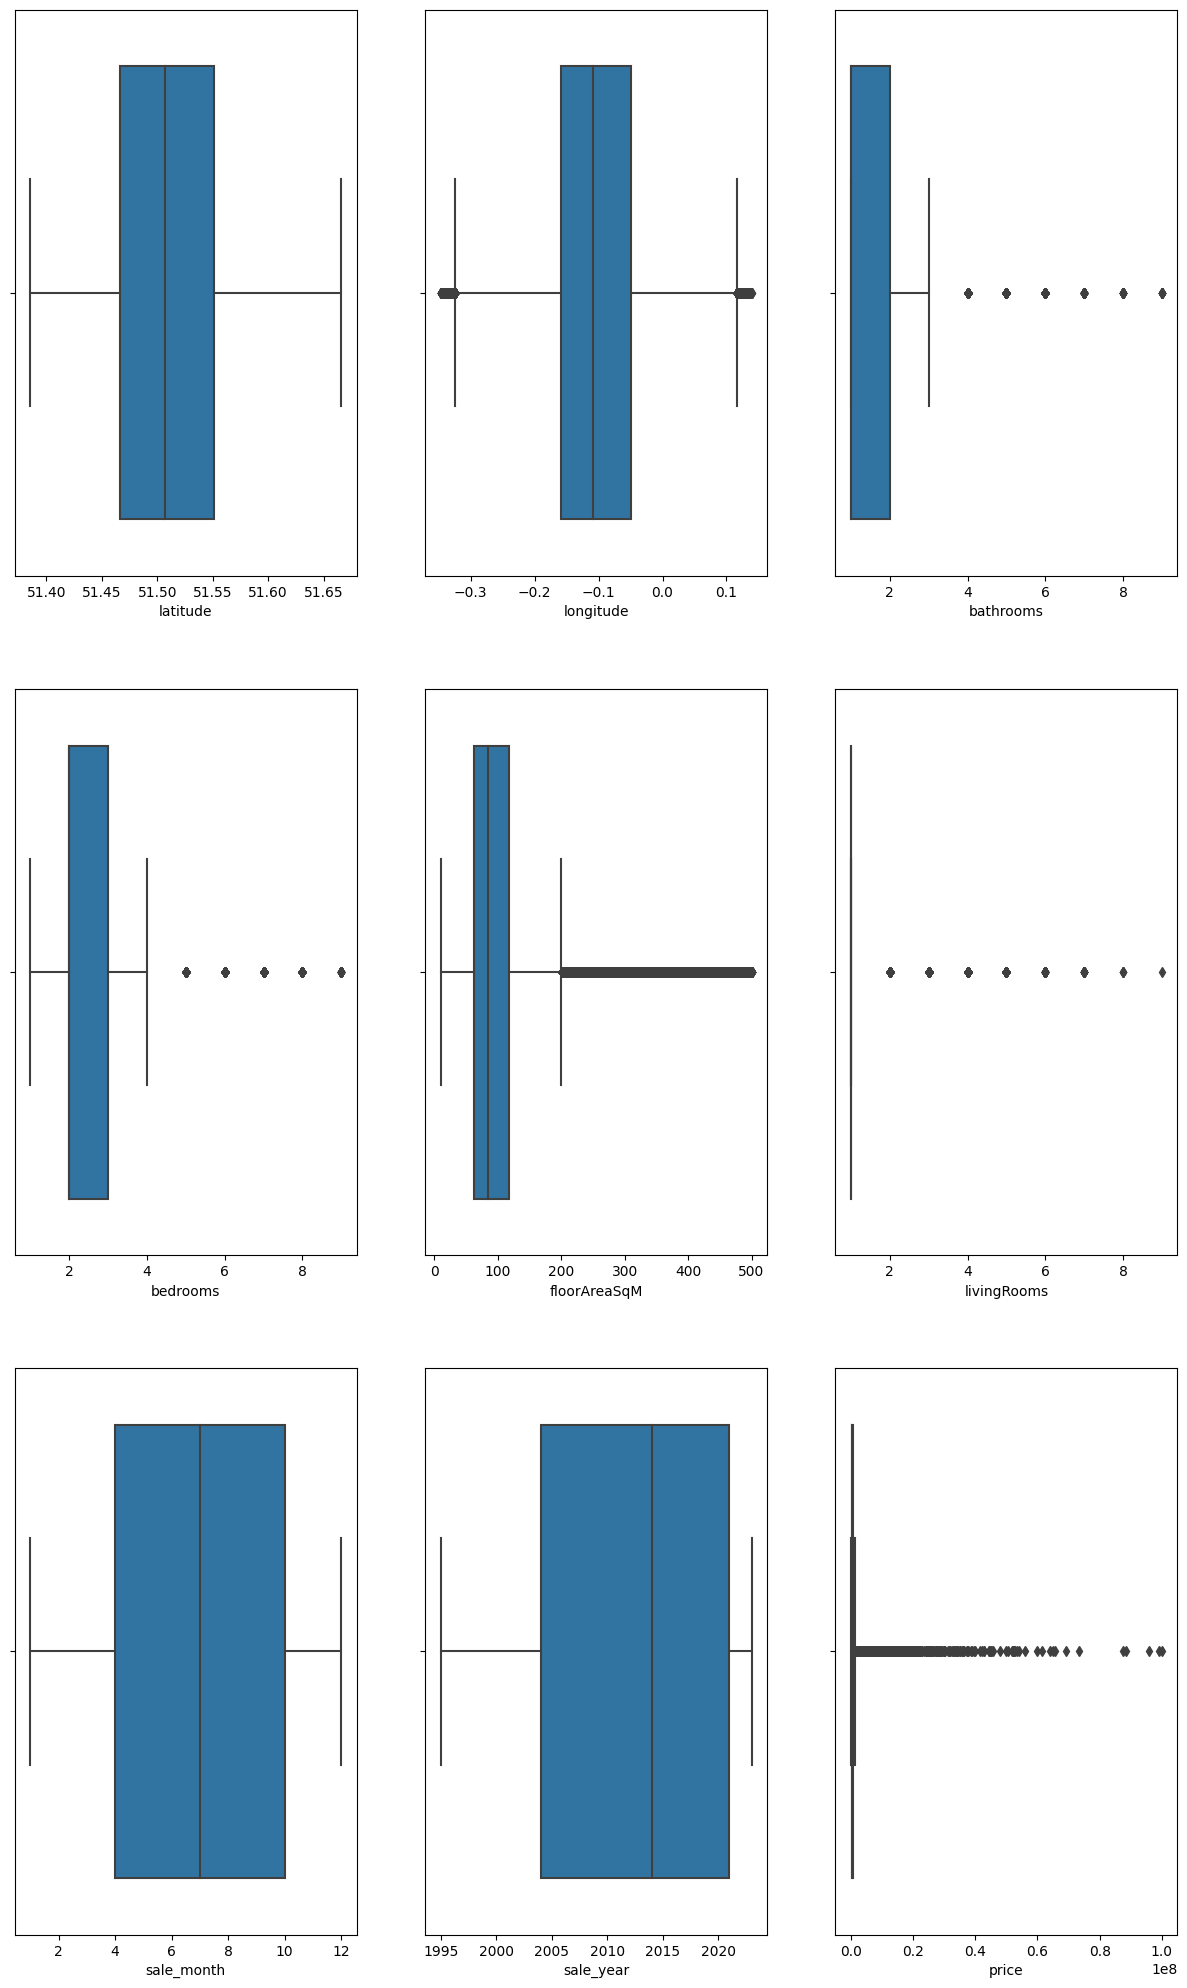

In [18]:
g, ax = plt.subplots(3, 3, figsize=(15, 25))
ax = ax.flatten()
for i, col in enumerate(train_df[num_features].columns):
    sns.boxplot(data = train_df, x = col, ax=ax[i])

## 3.3. univariate analysis

In [19]:
train_df.nunique()

ID                     266325
fullAddress            118345
postcode                45064
country                     1
outcode                   167
latitude                82653
longitude               83295
bathrooms                   9
bedrooms                    9
floorAreaSqM              488
livingRooms                 9
tenure                      4
propertyType               19
currentEnergyRating         7
sale_month                 12
sale_year                  29
price                   16882
time_numeric              348
dtype: int64

<Axes: xlabel='tenure', ylabel='count'>

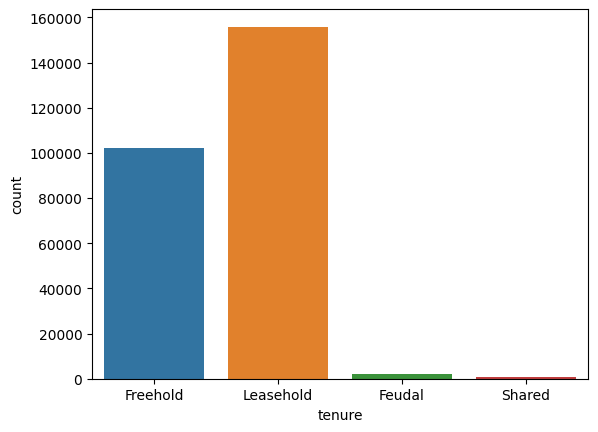

In [20]:
sns.countplot(data = train_df, x = 'tenure')

In [21]:
train_df['outcode'].value_counts()

outcode
SE18    4444
SW2     4440
N16     4163
SW4     4102
SW16    4006
        ... 
EC3V      17
EC2V       7
EC2R       7
W1C        3
EC3M       2
Name: count, Length: 167, dtype: int64

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

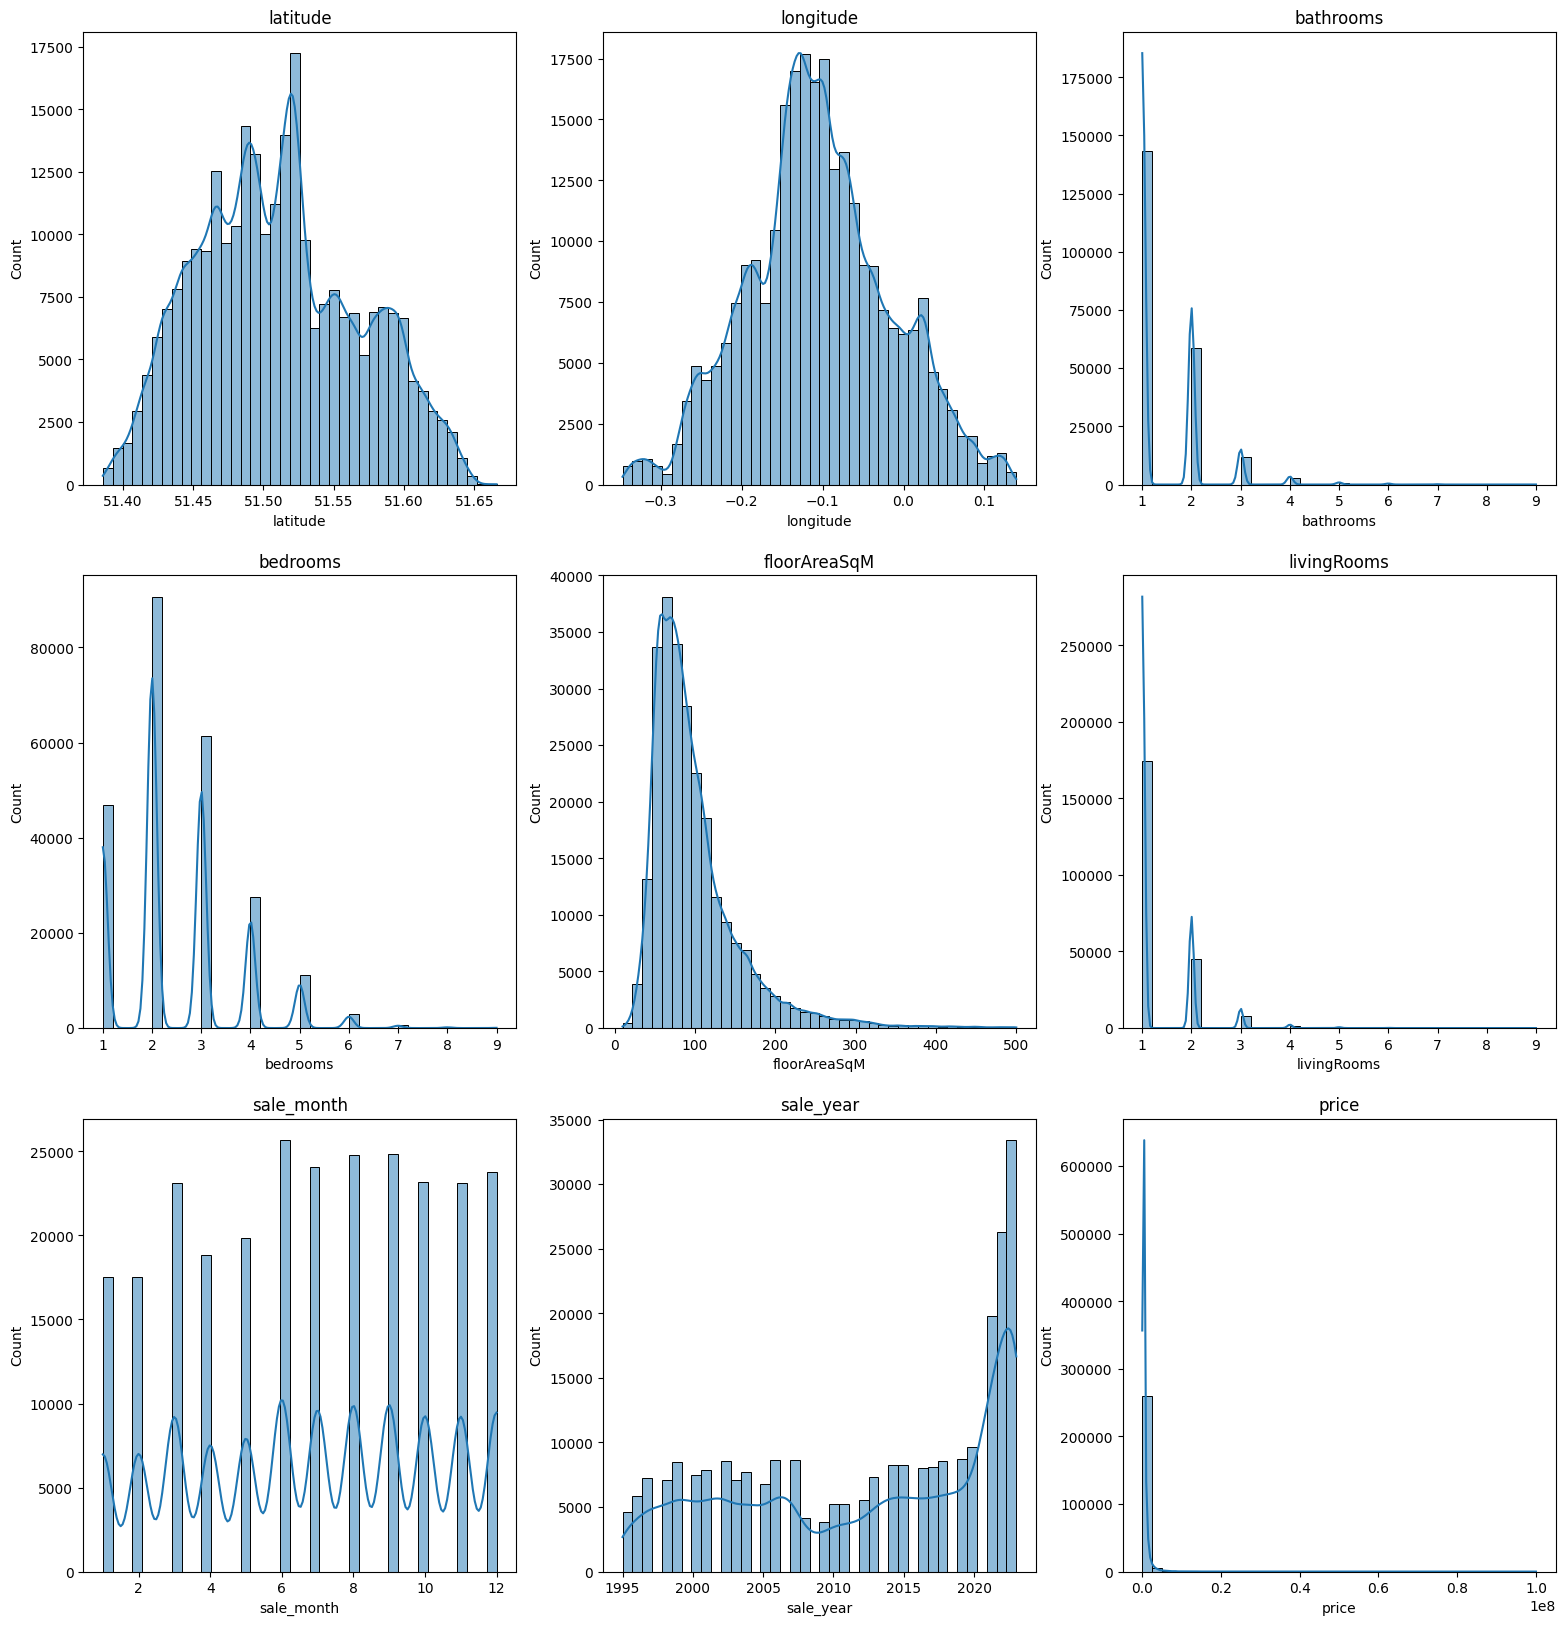

In [22]:
g, ax = plt.subplots(3, 3, figsize=(19, 20))
ax = ax.flatten()
for i, col in enumerate(train_df[num_features].columns):
    sns.histplot(data = train_df.dropna(subset = [col]), x = col, bins = 40, ax=ax[i], kde = True)
    ax[i].set_title(col)

In [23]:
train_df['price']

time
1995-01      77000
1995-01      89995
1995-01      59000
1995-01      51500
1995-01      63500
            ...   
2023-12     800000
2023-12     550000
2023-12     730000
2023-12    3275000
2023-12    6000000
Freq: M, Name: price, Length: 266325, dtype: int64

<Axes: xlabel='time'>

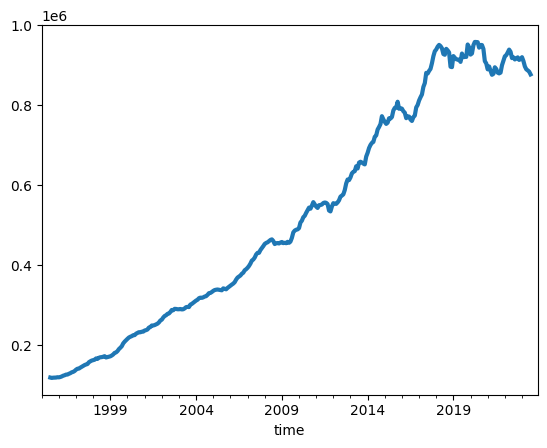

In [24]:
monthly_avg = train_df.groupby(train_df.index)['price'].mean()
moving_average = monthly_avg.rolling( \
    window = 12, \
    center = True, \
).mean()

moving_average.plot(linewidth=3, legend = False)

## 3.4. Multivariate analysis

### Feature - feature

/tmp/ipykernel_13/567284387.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  area_by_lat_bin = df.groupby('latitude_bin')['floorAreaSqM'].mean()


<Axes: xlabel='latitude_bin'>

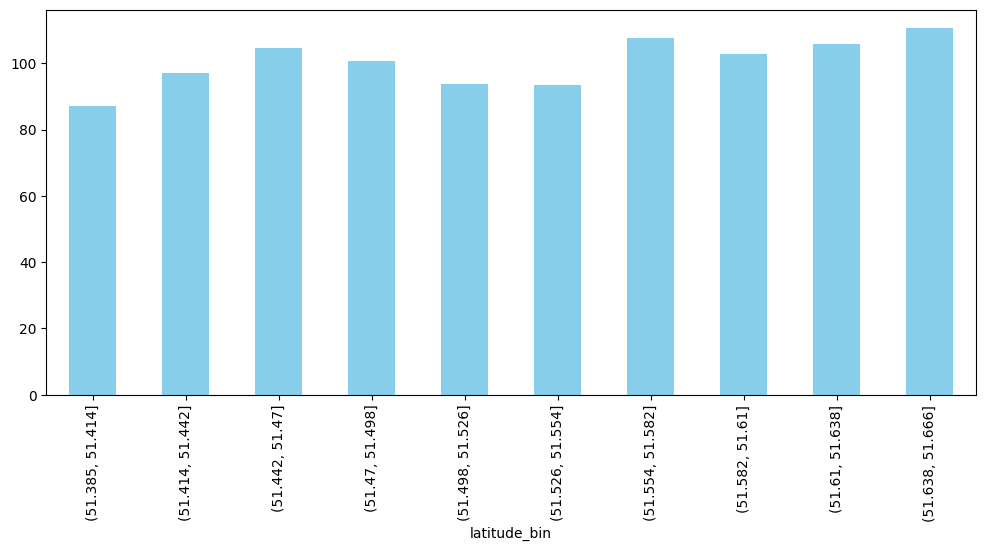

In [25]:
df = train_df.copy()
df['latitude_bin'] = pd.cut(df['latitude'], bins=10)

area_by_lat_bin = df.groupby('latitude_bin')['floorAreaSqM'].mean()

area_by_lat_bin.plot(kind='bar', figsize=(12, 5), color='skyblue')

/tmp/ipykernel_13/375673060.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  area_by_long_bin = df.groupby('longitude_bin')['floorAreaSqM'].mean()


<Axes: xlabel='longitude_bin'>

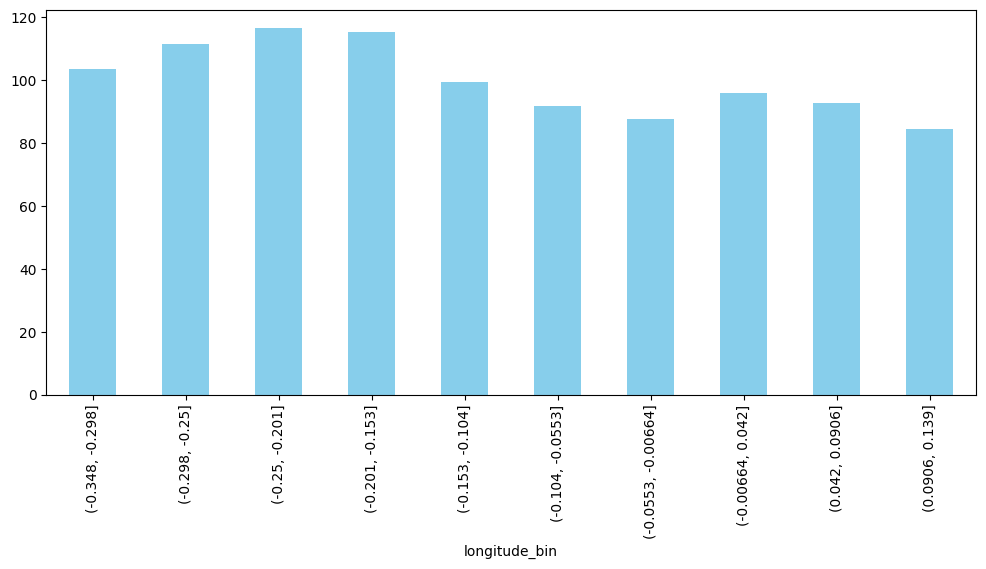

In [26]:
df = train_df.copy()
df['longitude_bin'] = pd.cut(df['longitude'], bins=10)

area_by_long_bin = df.groupby('longitude_bin')['floorAreaSqM'].mean()

area_by_long_bin.plot(kind='bar', figsize=(12, 5), color='skyblue')

### Feature - output

<Axes: xlabel='tenure'>

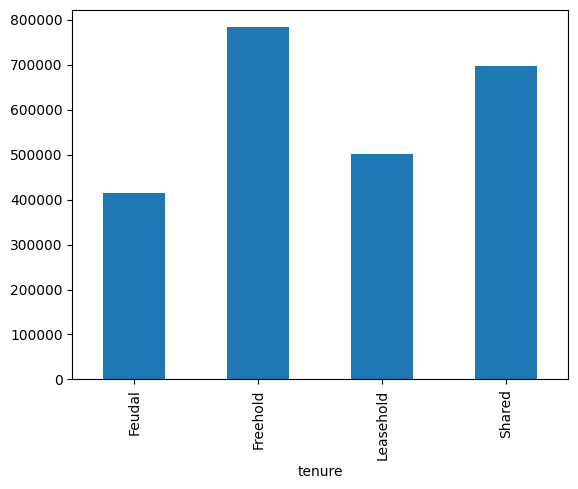

In [27]:
train_df.groupby('tenure')['price'].mean().plot(kind='bar')

In [28]:
train_df.groupby('outcode')['price'].mean()

outcode
E1      4.793123e+05
E10     3.367279e+05
E11     4.152501e+05
E12     3.545431e+05
E13     2.890680e+05
            ...     
WC2B    7.434365e+05
WC2E    1.257446e+06
WC2H    6.727223e+05
WC2N    7.429361e+05
WC2R    1.899948e+06
Name: price, Length: 167, dtype: float64

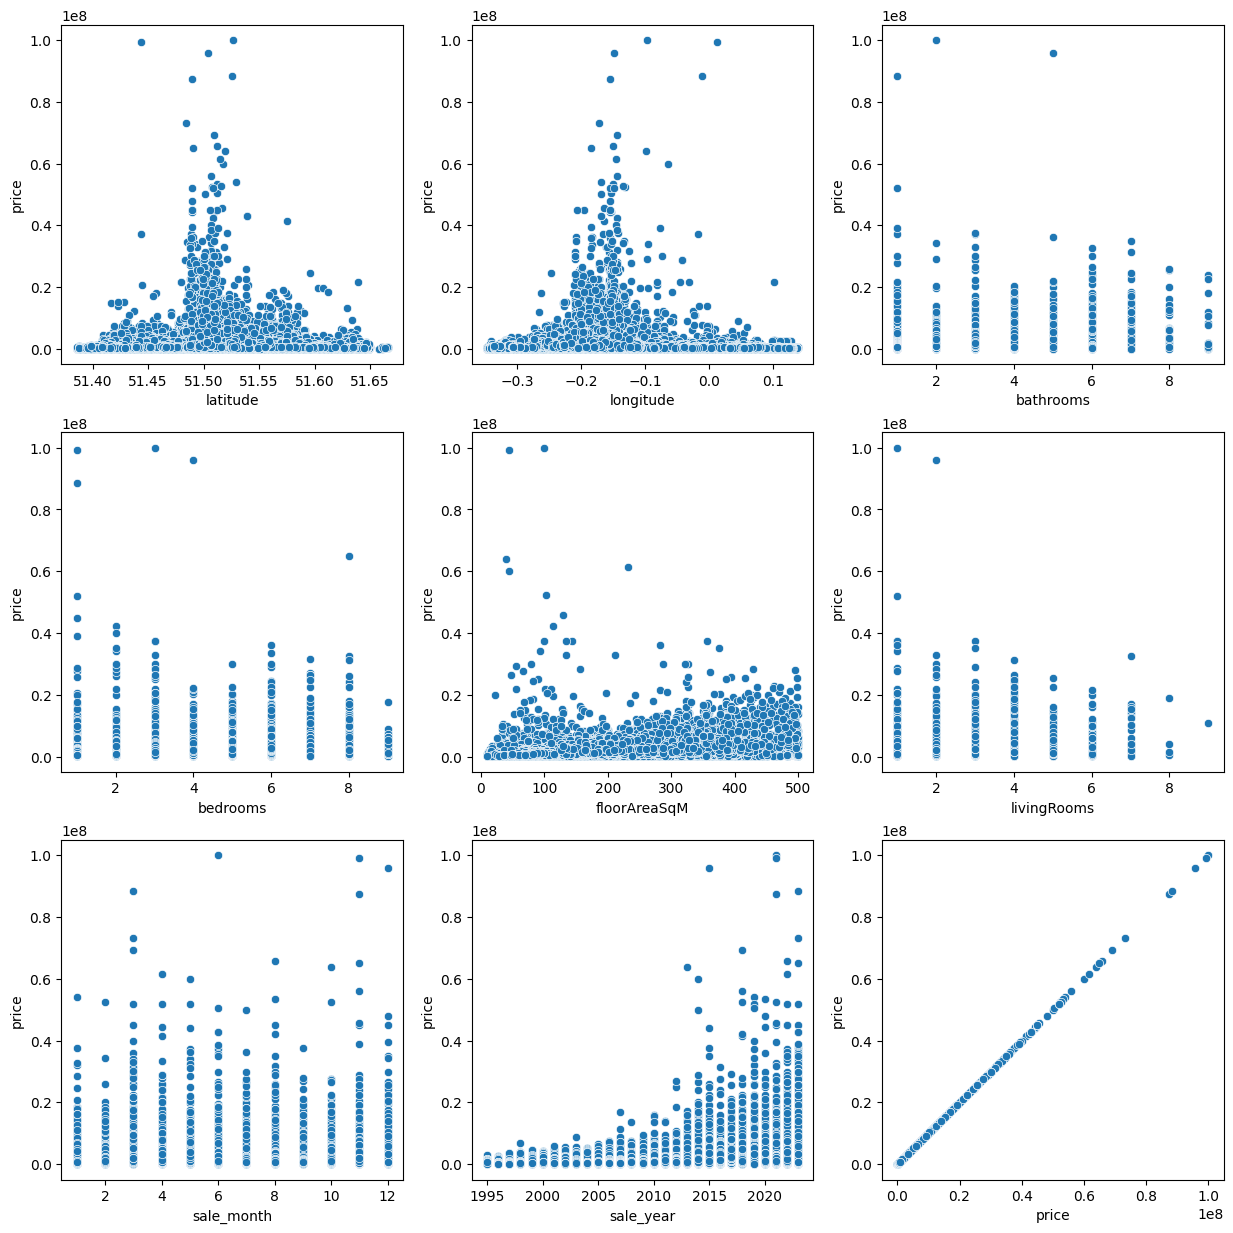

In [29]:
g, ax = plt.subplots(3, 3, figsize=(15, 15))
ax = ax.flatten()
for i, col in enumerate(train_df[num_features].columns):
    sns.scatterplot(data=train_df, x=col, y='price', ax = ax[i])

### Correlation Matrix

<Axes: >

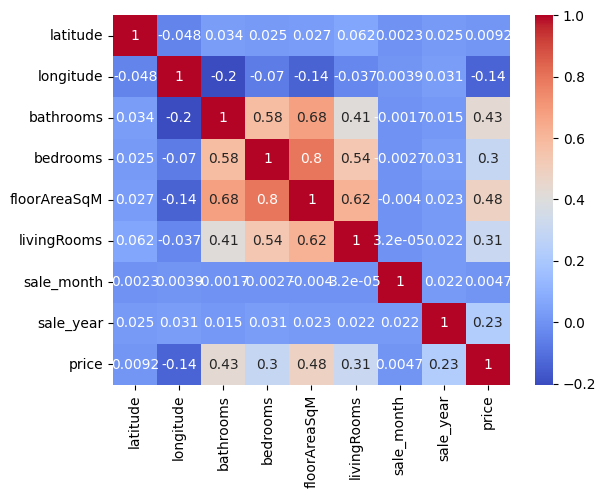

In [30]:
sns.heatmap(train_df[num_features].corr(),  cmap = 'coolwarm', annot=True)

## 3.5. Insights from Data Exploration
1. The country column can be dropped as it contains only one unique value.

2. Tenure values Feudal and Shared are rare.

3. Missing data in features: bathrooms, bedrooms, floorAreaSqM, livingRooms, tenure, propertyType, currentEnergyRating.

4. Possible outliers in: bathrooms, bedrooms, floorAreaSqM, livingRooms.

5. Price is mostly concentrated between 0 and 10,000,000.

6. Bathrooms and floorAreaSqM are moderately correlated with price.

7. Bathrooms, bedrooms, and floorAreaSqM are highly correlated with each other.

8. Latitude and Longitude show high-priced properties clustered in specific areas.

9. FloorAreaSqM shows a linear trend, unlike bathrooms, bedrooms, and livingRooms.

# **4. Wrangle data**

In [31]:
test_df['price'] = np.nan

## 4.1. Completing and Creating

### fullAddress

In [32]:
for data in combine:
    data['street'] = data['fullAddress'].apply(lambda z : ' '.join(z.split(',')[-3].split(' ')[-2:]))

In [33]:
train_df[['street']]

,street
time,
1995-01,Adelina Grove
1995-01,Cleveland Grove
1995-01,Sanderstead Road
1995-01,Queenswood Gardens
1995-01,Woodlands Road
...,...
2023-12,Acton Street
2023-12,Margery Street
2023-12,Stukeley Street


In [34]:
len(train_df['street'].unique())

16606

In [35]:
len(set(train_df['street']) | set(test_df['street']))

16856

### postcode

In [36]:
for data in combine:
    data['postcode'] = data['postcode'].apply(lambda x : x.split(' ')[1])

### country

In [37]:
for data in combine:
    data.drop('country', axis = 1, inplace = True)

### latitude

Do nothing

### longitude

Do nothing

### floorAreaSqM

In [38]:
def get_mode(x):
    return x.mode().iloc[0] if not x.mode().empty else np.nan

In [39]:
df = pd.DataFrame({
    'min': train_df.groupby('outcode')['floorAreaSqM'].min(),
    'max': train_df.groupby('outcode')['floorAreaSqM'].max(),
    'mode': train_df.groupby('outcode')['floorAreaSqM'].apply(get_mode),
    'mean': train_df.groupby('outcode')['floorAreaSqM'].mean(),
    'count': train_df.groupby('outcode')['floorAreaSqM'].count()
})

df

,min,max,mode,mean,count
outcode,,,,,
E1,17.0,377.0,55.0,75.373476,1968
E10,17.0,263.0,62.0,84.419477,2105
E11,28.0,335.0,64.0,98.563623,2782
E12,32.0,482.0,56.0,102.874260,1352
E13,12.0,221.0,82.0,87.119629,1187
...,...,...,...,...,...
WC2B,26.0,406.0,50.0,71.446650,403
WC2E,30.0,348.0,52.0,89.807692,312
WC2H,24.0,470.0,56.0,75.728198,688


In [40]:
df = pd.DataFrame({
    'min': train_df.groupby('postcode')['floorAreaSqM'].min(),
    'max': train_df.groupby('postcode')['floorAreaSqM'].max(),
    'mode': train_df.groupby('postcode')['floorAreaSqM'].apply(get_mode),
    'mean': train_df.groupby('postcode')['floorAreaSqM'].mean(),
    'count': train_df.groupby('postcode')['floorAreaSqM'].count()
})

df

,min,max,mode,mean,count
postcode,,,,,
0AA,34.0,498.0,98.0,129.517986,139
0AB,27.0,322.0,79.0,105.497674,215
0AD,24.0,255.0,59.0,120.644444,135
0AE,35.0,249.0,55.0,105.577778,90
0AF,40.0,304.0,82.0,109.021739,92
...,...,...,...,...,...
9YP,51.0,51.0,51.0,51.000000,5
9YY,63.0,70.0,65.0,66.750000,8
9ZJ,38.0,38.0,38.0,38.000000,2


In [41]:
si = SimpleImputer(strategy = 'most_frequent')
si.fit(train_df[['floorAreaSqM']])
for data in combine:
    data['floorAreaSqM'] = si.transform(data[['floorAreaSqM']]).ravel()

### bathrooms

In [42]:
train_no_missing = train_df.dropna(subset=['bathrooms', 'floorAreaSqM'])
X_train = train_no_missing[['floorAreaSqM']]
y_train = train_no_missing['bathrooms']

model = Ridge()
model.fit(X_train, y_train)

missing_train = train_df[train_df['bathrooms'].isna()]
missing_test = test_df[test_df['bathrooms'].isna()]

train_df.loc[train_df['bathrooms'].isna(), 'bathrooms'] = model.predict(missing_train[['floorAreaSqM']])
test_df.loc[test_df['bathrooms'].isna(), 'bathrooms'] = model.predict(missing_test[['floorAreaSqM']])
combine = [train_df, test_df]

### bedrooms

In [43]:
train_no_missing = train_df.dropna(subset=['bedrooms', 'floorAreaSqM'])
X_train = train_no_missing[['floorAreaSqM']]
y_train = train_no_missing['bedrooms']

model = Ridge()
model.fit(X_train, y_train)

missing_train = train_df[train_df['bedrooms'].isna()]
missing_test = test_df[test_df['bedrooms'].isna()]

train_df.loc[train_df['bedrooms'].isna(), 'bedrooms'] = model.predict(missing_train[['floorAreaSqM']])
test_df.loc[test_df['bedrooms'].isna(), 'bedrooms'] = model.predict(missing_test[['floorAreaSqM']])
combine = [train_df, test_df]

### livingRooms

In [44]:
si = SimpleImputer(strategy = 'most_frequent')
si.fit(train_df[['livingRooms']])
for data in combine:
    data['livingRooms'] = si.transform(data[['livingRooms']]).ravel()

### tenure

In [45]:
si = SimpleImputer(strategy = 'most_frequent')
si.fit(train_df[['tenure']])
for data in combine:
    data['tenure'] = si.transform(data[['tenure']]).ravel()

### propertyType

In [46]:
si = SimpleImputer(strategy = 'most_frequent')
si.fit(train_df[['propertyType']])
for data in combine:
    data['propertyType'] = si.transform(data[['propertyType']]).ravel()

### currentEnergyRating

In [47]:
si = SimpleImputer(strategy = 'most_frequent')
si.fit(train_df[['currentEnergyRating']])
for data in combine:
    data['currentEnergyRating'] = si.transform(data[['currentEnergyRating']]).ravel()

### sale_month & sale_year

In [48]:
forecast_origin = train_df.index.max()
forecast_lead = test_df.index.min() - forecast_origin
forecast_horizon = test_df.index.max() - test_df.index.min()
# strategy: DirRec

print("Forecast origin:", forecast_origin)
print("Lead time:", forecast_lead.n)
print("Forecast horizon (months):", forecast_horizon.n)

Forecast origin: 2023-12
Lead time: 1
Forecast horizon (months): 7


In [49]:
dp_train = DeterministicProcess(
    index = train_df.index.unique(),
    constant = True,
    seasonal = True,
    order = 12,
    drop = True,
    additional_terms = [CalendarFourier(freq="QE", order=4)],
)

tmp_train = dp_train.in_sample()

train_df = train_df.join(tmp_train, how = 'left')

In [50]:
tmp_test = dp_train.out_of_sample(steps = forecast_horizon.n + forecast_lead.n)

test_df = test_df.join(tmp_test, how = 'left')
test_df.index.name = 'time'

In [51]:
combine = [train_df, test_df]

In [52]:
def make_lags(ts, lags, lead_time = 1):
    return pd.concat({f'lag_{i}': ts.shift(i) for i in range(lead_time, lags + lead_time)}, axis = 1)

### bathrooms & bedrooms & livingRooms

In [53]:
for data in combine:
    data['rooms'] = data['bedrooms'] + data['livingRooms']

## 4.2. Encoder

In [54]:
train_df.isnull().sum()

ID                     0
fullAddress            0
postcode               0
outcode                0
latitude               0
longitude              0
bathrooms              0
bedrooms               0
floorAreaSqM           0
livingRooms            0
tenure                 0
propertyType           0
currentEnergyRating    0
sale_month             0
sale_year              0
price                  0
time_numeric           0
street                 0
const                  0
trend                  0
trend_squared          0
trend_cubed            0
trend**4               0
rooms                  0
dtype: int64

In [55]:
test_df.head()

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pan

,ID,fullAddress,postcode,outcode,latitude,longitude,bathrooms,bedrooms,floorAreaSqM,livingRooms,...,sale_year,time_numeric,price,street,const,trend,trend_squared,trend_cubed,trend**4,rooms
time,,,,,,,,,,,,,,,,,,,,,
2024-01,266325,"Flat 7, Philip House, Heneage Street, London, ...",5LW,E1,51.518783,-0.071003,1.0,2.000000,54.0,1.0,...,2024,0.0,NaN,Heneage Street,1.0,349.0,121801.0,42508549.0,1.483548e+10,3.000000
2024-01,266326,"17 Bowmans Mews, London, E1 8RY",8RY,E1,51.511624,-0.068236,1.0,1.000000,48.0,1.0,...,2024,0.0,NaN,Bowmans Mews,1.0,349.0,121801.0,42508549.0,1.483548e+10,2.000000
2024-01,266327,"Flat 30, Everard House, Boyd Street, London, E...",1LY,E1,51.512737,-0.066502,1.0,1.397534,32.0,1.0,...,2024,0.0,NaN,Boyd Street,1.0,349.0,121801.0,42508549.0,1.483548e+10,2.397534
2024-01,266328,"Flat 1, Wilton Court, Cavell Street, London, E...",2BN,E1,51.516165,-0.057334,1.0,3.000000,85.0,1.0,...,2024,0.0,NaN,Cavell Street,1.0,349.0,121801.0,42508549.0,1.483548e+10,4.000000
2024-01,266329,"45 Musbury Street, London, E1 0PJ",0PJ,E1,51.515115,-0.051008,1.0,2.000000,82.0,1.0,...,2024,0.0,NaN,Musbury Street,1.0,349.0,121801.0,42508549.0,1.483548e+10,3.000000


In [56]:
test_df.isnull().sum()

ID                         0
fullAddress                0
postcode                   0
outcode                    0
latitude                   0
longitude                  0
bathrooms                  0
bedrooms                   0
floorAreaSqM               0
livingRooms                0
tenure                     0
propertyType               0
currentEnergyRating        0
sale_month                 0
sale_year                  0
time_numeric               0
price                  16547
street                     0
const                      0
trend                      0
trend_squared              0
trend_cubed                0
trend**4                   0
rooms                      0
dtype: int64

In [57]:
class Encoder(BaseEstimator, TransformerMixin):
    '''
    // street, postcode, outcode, tenure, latitudeBins, longitudeBins, propertyType, currentEnergyRating
    '''
    def __init__(self):
        self.encoder1 = {}
        self.encoder2 = {}


    def fit(self, X, y=None):
        X = X.copy()
        X['price'] = y
        # street
        self.encoder1['street'] = X.groupby('street')['price'].mean()
        self.encoder2['street'] = self.encoder1['street'].mean()
        # postcode
        self.encoder1['postcode'] = X.groupby('postcode')['price'].mean()
        self.encoder2['postcode'] = self.encoder1['postcode'].mean()
        #outcode
        self.encoder1['outcode'] = X.groupby('outcode')['price'].mean()
        self.encoder2['outcode'] = self.encoder1['outcode'].mean()
        # tenure
        self.encoder1['tenure'] = X.groupby('tenure')['price'].mean()
        self.encoder2['tenure'] = self.encoder1['tenure'].mean()
        # latitude
        self.encoder1['latitudeBins'] = pd.cut(X['latitude'], bins = 10, retbins = True)[1]
        latitude_labels = pd.cut(X['latitude'], bins=self.encoder1['latitudeBins'], include_lowest=True)
        lb = LabelEncoder()
        self.encoder2['latitudeBins'] = lb.fit(latitude_labels)
        # longitude
        self.encoder1['longitudeBins'] = pd.cut(X['longitude'], bins = 10, retbins = True)[1]
        longitude_labels = pd.cut(X['longitude'], bins=self.encoder1['longitudeBins'], include_lowest=True)
        lb = LabelEncoder()
        self.encoder2['longitudeBins'] = lb.fit(longitude_labels)
        # propertyType
        self.encoder1['propertyType'] = X.groupby('propertyType')['price'].mean()
        self.encoder2['propertyType'] = self.encoder1['propertyType'].mean()
        # currentEnergyRating
        custom_order = [['G', 'F', 'E', 'D', 'C', 'B', 'A']]
        lb = OrdinalEncoder(categories=custom_order)
        self.encoder1['currentEnergyRating'] = lb.fit(X[['currentEnergyRating']])
        return self

    def transform(self, X):
        X = X.copy()
        # street
        X['street'] = X['street'].map(self.encoder1['street'])
        X['street'] = X['street'].fillna(self.encoder2['street'])
        #postcode
        X['postcode'] = X['postcode'].map(self.encoder1['postcode'])
        X['postcode'] = X['postcode'].fillna(self.encoder2['postcode'])
        #outcode
        X['outcode'] = X['outcode'].map(self.encoder1['outcode'])
        X['outcode'] = X['outcode'].fillna(self.encoder2['outcode'])
        # tenure
        X['tenure'] = X['tenure'].map(self.encoder1['tenure'])
        X['tenure'] = X['tenure'].fillna(self.encoder2['tenure'])
        # latitude
        X['latitudeBins'] = pd.cut(X['latitude'], bins = self.encoder1['latitudeBins'], include_lowest=True, right=True)
        X['latitudeBins'] = self.encoder2['latitudeBins'].transform(X['latitudeBins'])
        # longitude
        X['longitudeBins'] = pd.cut(X['longitude'], bins = self.encoder1['longitudeBins'], include_lowest=True, right=True)
        X['longitudeBins'] = self.encoder2['longitudeBins'].transform(X['longitudeBins'])
        # propertyType
        X['propertyType'] = X['propertyType'].map(self.encoder1['propertyType'])
        X['propertyType'] = X['propertyType'].fillna(self.encoder2['propertyType'])
        # currentEnergyRating
        X['currentEnergyRating'] = self.encoder1['currentEnergyRating'].transform(X[['currentEnergyRating']])
        return X

# **5. Chosing feature**

In [58]:
X1_feature = tmp_train.columns.tolist()
X2_feature = ['street', 'postcode', 'outcode', 'latitudeBins', \
              'longitudeBins', 'bathrooms', 'bedrooms', 'rooms', 'floorAreaSqM', 'livingRooms', \
              'tenure', 'propertyType', 'currentEnergyRating']

X_train = train_df.drop('price', axis = 1)
y_train = train_df['price']

In [59]:
X_train.head()

,ID,fullAddress,postcode,outcode,latitude,longitude,bathrooms,bedrooms,floorAreaSqM,livingRooms,...,sale_month,sale_year,time_numeric,street,const,trend,trend_squared,trend_cubed,trend**4,rooms
time,,,,,,,,,,,,,,,,,,,,,
1995-01,0,"38 Adelina Grove, London, E1 3AD",3AD,E1,51.519406,-0.053261,1.28399,3.0,80.0,1.0,...,1,1995,0.0,Adelina Grove,1.0,1.0,1.0,1.0,1.0,4.0
1995-01,1,"6 Cleveland Grove, London, E1 4XL",4XL,E1,51.521261,-0.053384,2.00000,4.0,110.0,1.0,...,1,1995,0.0,Cleveland Grove,1.0,1.0,1.0,1.0,1.0,5.0
1995-01,2,"65 Sanderstead Road, London, E10 7PW",7PW,E10,51.569054,-0.034892,1.00000,3.0,84.0,1.0,...,1,1995,0.0,Sanderstead Road,1.0,1.0,1.0,1.0,1.0,4.0
1995-01,3,"5 Queenswood Gardens, London, E11 3SE",3SE,E11,51.564212,0.026292,1.21722,2.0,72.0,1.0,...,1,1995,0.0,Queenswood Gardens,1.0,1.0,1.0,1.0,1.0,3.0
1995-01,4,"12 Woodlands Road, London, E11 4RW",4RW,E11,51.563430,0.006260,1.00000,3.0,104.0,1.0,...,1,1995,0.0,Woodlands Road,1.0,1.0,1.0,1.0,1.0,4.0


In [60]:
y_train.head()

time
1995-01    77000
1995-01    89995
1995-01    59000
1995-01    51500
1995-01    63500
Freq: M, Name: price, dtype: int64

In [61]:
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", test_df.shape)

X_train shape: (266325, 23)
y_train shape: (266325,)
X_test shape: (16547, 24)


# **5. Modeling**

In [62]:
scaler = StandardScaler()
X_train[X1_feature] = scaler.fit_transform(X_train[X1_feature])
test_df[X1_feature] = scaler.transform(test_df[X1_feature])

In [63]:
class HybridModel(BaseEstimator, RegressorMixin):
    def __init__(self, trend_model, machine_model, trend_cols, machine_cols, all_columns):
        self.trend_model = trend_model
        self.machine_model = machine_model
        self.trend_cols = trend_cols
        self.machine_cols = machine_cols
        self.all_columns = all_columns

    def fit(self, X, y):
        y = np.log1p(y) 
        
        if not isinstance(X, pd.DataFrame):
            X = pd.DataFrame(X, columns=self.all_columns)
        
        X1 = X[self.trend_cols]
        X2 = X[self.machine_cols]
        self.trend_model.fit(X1, y)
        trend_pred = self.trend_model.predict(X1)
        residual = y - trend_pred
        self.machine_model.fit(X2, residual)
        return self

    def predict(self, X):
        if not isinstance(X, pd.DataFrame):
            X = pd.DataFrame(X, columns=self.all_columns)
        X1 = X[self.trend_cols]
        X2 = X[self.machine_cols]
        trend_pred = self.trend_model.predict(X1)
        machine_pred = self.machine_model.predict(X2)
        return np.expm1(trend_pred + machine_pred)

In [64]:
model = {
    'HybridModel': Pipeline([
        ('Encoder', Encoder()),
        ('Model', HybridModel(
            trend_model = Ridge(),
            machine_model = XGBRegressor(),
            trend_cols = X1_feature,
            machine_cols = X2_feature,
            all_columns = X_train.columns
        ))
    ]),
}

# **6. Grid search**

In [65]:
params_grid = {
    'HybridModel': {
        'Model__trend_model__alpha': [0.01, 0.1],
        'Model__machine_model__n_estimators': [500],
        'Model__machine_model__max_depth': [9],
        'Model__machine_model__learning_rate': [0.01, 0.005, 0.1],
    }
}

In [66]:
best_model = {}
for name, pipeline in model.items():
  grid_search = GridSearchCV(pipeline, params_grid[name], cv=5, scoring='neg_mean_absolute_error', n_jobs = -1, verbose = 2, error_score='raise')
  grid_search.fit(X_train, y_train)
  print(name, ':', grid_search.best_params_, ' mae:', -grid_search.best_score_)
  best_model[name] = grid_search.best_estimator_

Fitting 5 folds for each of 6 candidates, totalling 30 fits
HybridModel : {'Model__machine_model__learning_rate': 0.1, 'Model__machine_model__max_depth': 9, 'Model__machine_model__n_estimators': 500, 'Model__trend_model__alpha': 0.01}  mae: 164300.68519168062


# **7. Chosing models**

In [67]:
model_chosens = [
    ('HybridModel', best_model['HybridModel']),
]

In [68]:
combine_model = VotingRegressor(estimators = model_chosens)

# **8. Retrain all**

In [69]:
combine_model.fit(X_train, y_train)

VotingRegressor(estimators=[('HybridModel',
                             Pipeline(steps=[('Encoder', Encoder()),
                                             ('Model',
                                              HybridModel(all_columns=Index(['ID', 'fullAddress', 'postcode', 'outcode', 'latitude', 'longitude',
       'bathrooms', 'bedrooms', 'floorAreaSqM', 'livingRooms', 'tenure',
       'propertyType', 'currentEnergyRating', 'sale_month', 'sale_year',
       'time_numeric', 'street', 'const', 'trend', 'tr...
                                                                                     max_cat_threshold=None,
                                                                                     max_cat_to_onehot=None,
                                                                                     max_delta_step=None,
                                                                                     max_depth=9,
                                                                                     max_leaves=None,
                                                                                     min_child_weight=None,
                                                                                     missing=nan,
                                                                                     monotone_constraints=None,
                                                                                     multi_strategy=None,
                                                                                     n_estimators=500,
                                                                                     n_jobs=None,
                                                                                     num_parallel_tree=None,
                                                                                     random_state=None, ...),
                                                          trend_cols=['const',
                                                                      'trend',
                                                                      'trend_squared',
                                                                      'trend_cubed',
                                                                      'trend**4'],
                                                          trend_model=Ridge(alpha=0.01)))]))])

# **9. Build submission**

In [70]:
submission = pd.read_csv('/kaggle/input/london-house-price-prediction-advanced-techniques/sample_submission.csv')
submission['price'] = combine_model.predict(test_df.drop('price', axis = 1))
submission.to_csv('submission.csv', index=False)